In [1]:
!pip install -q kaggle

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"alfirafibri","key":"f7da36b7a4235f5cc492ddbc041e0217"}'}

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!ls ~/.kaggle

kaggle.json


In [4]:
!kaggle datasets download -d andrewmvd/animal-faces

 99% 691M/696M [00:05<00:00, 141MB/s]
100% 696M/696M [00:05<00:00, 130MB/s]


In [5]:
# direktori baru
!mkdir datapict
!unzip -qq animal-faces.zip -d datapict
!ls datapict

afhq


In [6]:
!sudo apt install tree

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
The following NEW packages will be installed:
  tree
0 upgraded, 1 newly installed, 0 to remove and 20 not upgraded.
Need to get 40.7 kB of archives.
After this operation, 105 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tree amd64 1.7.0-5 [40.7 kB]
Fetched 40.7 kB in 0s (138 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: 

In [7]:
# melihat susunan direktori
!tree -d datapict/

datapict/
└── afhq
    ├── animal
    │   ├── cat
    │   ├── dog
    │   └── wild
    └── val
        ├── cat
        ├── dog
        └── wild

9 directories


In [8]:
# hapus direktori
import shutil

shutil.rmtree('datapict/afhq/val')

In [9]:
!tree -d datapict/

datapict/
└── afhq
    └── animal
        ├── cat
        ├── dog
        └── wild

5 directories


In [10]:
!pip install split_folders tqdm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [11]:
import splitfolders

splitfolders.ratio('datapict/afhq/animal/', output = 'datapict/afhq/animal/data_model', seed = 3, ratio = (0.8, 0.2))

Copying files: 14630 files [00:04, 3553.01 files/s]


In [12]:
import os

base_dir = 'datapict/afhq/animal/data_model'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'val')

train_cat_dir = os.path.join(train_dir, 'cat')
train_dog_dir = os.path.join(train_dir, 'dog')
train_wild_dir = os.path.join(train_dir, 'wild')

validation_cat_dir = os.path.join(validation_dir, 'cat')
validation_dog_dir = os.path.join(validation_dir, 'dog')
validation_wild_dir = os.path.join(validation_dir, 'wild')

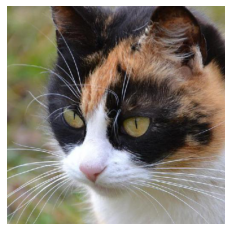

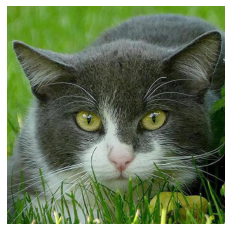

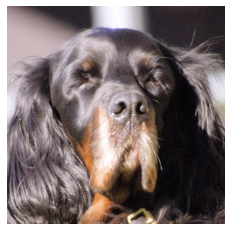

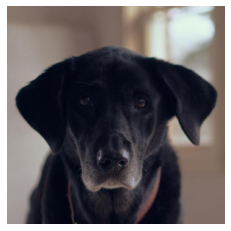

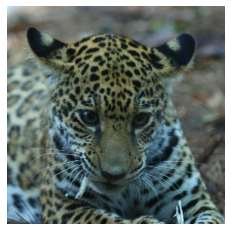

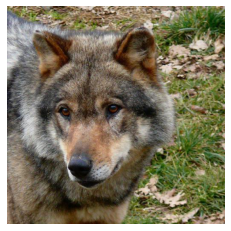

In [40]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

cat_files = os.listdir(train_cat_dir)
dog_files = os.listdir(train_dog_dir)
wild_files = os.listdir(train_wild_dir)

pic_index = random.randrange(0, 1000)

next_cat = [os.path.join(train_cat_dir, fname) 
                for fname in cat_files[pic_index-2:pic_index]]
next_dog = [os.path.join(train_dog_dir, fname) 
                for fname in dog_files[pic_index-2:pic_index]]
next_wild = [os.path.join(train_wild_dir, fname) 
                for fname in wild_files[pic_index-2:pic_index]]

for i, img_path in enumerate(next_cat + next_dog + next_wild):
  img = mpimg.imread(img_path)
  plt.imshow(img)
  plt.axis('Off')
  plt.show()

In [26]:
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True,
                                   shear_range = 0.2,
                                   fill_mode = 'nearest')
 
test_datagen = ImageDataGenerator(rescale = 1./255,
                                  rotation_range = 40,
                                  width_shift_range = 0.2,
                                  height_shift_range = 0.2,
                                  zoom_range = 0.2,
                                  horizontal_flip = True,
                                  shear_range = 0.2,
                                  fill_mode = 'nearest')

train_generator = train_datagen.flow_from_directory(
    train_dir,  # direktori data latih
    target_size = (150, 150),  
    batch_size = 20,
    class_mode = 'categorical')
 
validation_generator = test_datagen.flow_from_directory(
    validation_dir, # direktori data validasi
    target_size = (150, 150), 
    batch_size = 20, 
    class_mode = 'categorical')

Found 11703 images belonging to 3 classes.
Found 2927 images belonging to 3 classes.


In [27]:
tf.device('/device:GPU:0')

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, (3,3), activation = 'relu', input_shape = (150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3,3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5), 
    tf.keras.layers.Dense(512, activation = 'relu'),
    tf.keras.layers.Dense(3, activation = 'softmax')
])

In [28]:
model.compile(optimizer = 'adam',
              loss = 'categorical_crossentropy',
              metrics = ['accuracy']
              )

In [30]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs = {}):
    if(logs.get('accuracy') > 0.90 and logs.get('val_accuracy') > 0.90):
      print("\nAccuration more than 90%, training done!")
      self.model.stop_training = True

callbacks = myCallback()

In [31]:
history = model.fit(train_generator, 
                    epochs = 100, 
                    steps_per_epoch = 32,
                    validation_data = validation_generator, 
                    validation_steps = 8,
                    verbose = 1,
                    callbacks = [callbacks])

Epoch 1/100
32/32 [==============================] - 49s 2s/step - loss: 1.1032 - accuracy: 0.3391 - val_loss: 1.0958 - val_accuracy: 0.4563
Epoch 2/100
32/32 [==============================] - 47s 1s/step - loss: 1.0901 - accuracy: 0.3859 - val_loss: 1.0780 - val_accuracy: 0.3750
Epoch 3/100
32/32 [==============================] - 47s 1s/step - loss: 1.0984 - accuracy: 0.3906 - val_loss: 1.0946 - val_accuracy: 0.3688
Epoch 4/100
32/32 [==============================] - 47s 1s/step - loss: 1.0946 - accuracy: 0.3531 - val_loss: 1.0731 - val_accuracy: 0.4500
Epoch 5/100
32/32 [==============================] - 47s 1s/step - loss: 1.0717 - accuracy: 0.4141 - val_loss: 1.0084 - val_accuracy: 0.4688
Epoch 6/100
32/32 [==============================] - 47s 1s/step - loss: 1.0407 - accuracy: 0.4344 - val_loss: 1.0338 - val_accuracy: 0.4437
Epoch 7/100
32/32 [==============================] - 46s 1s/step - loss: 1.0088 - accuracy: 0.5016 - val_loss: 1.0234 - val_accuracy: 0.4938
Epoch 8/100
3

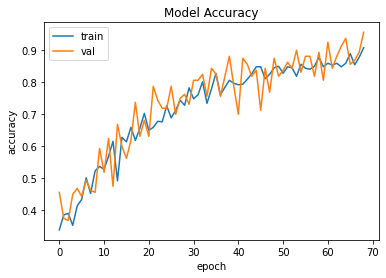

In [32]:
import numpy as np
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc = 'upper left')
plt.show()

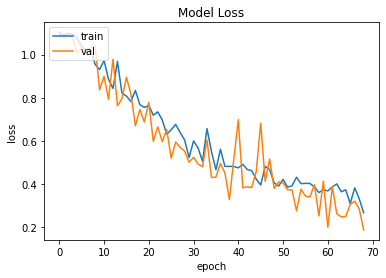

In [33]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc = 'upper left')
plt.show()

In [34]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with tf.io.gfile.GFile('model.tflite', 'wb') as f:
  f.write(tflite_model)

In [35]:
!ls -la | grep 'model'

-rw-r--r-- 1 root root  13898264 Sep 11 10:41 model.tflite
